# 3. Data Preprocessing


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/object-detection/Ch3-preprocessing.ipynb)

In chapter 2, we explored the data in the Face Mask Detection dataset. In this chapter, we will perform data preprocessing.

Popular datasets have tens of thousands of images, but many datasets are created on a much smaller scale, raising the question of how to train a limited dataset.

You don't have to find new images just because your dataset is limited. Instead, various images can be obtained using data augmentation.

![](https://github.com/Pseudo-Lab/Tutorial-Book/blob/master/book/pics/OD-ch3img01.jpeg?raw=true)

- Figure 3-1 Looks the same but is a different tennis ball (Source: https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/ )

Figure 3-1 shows tennis balls that look identical to human eyes. However, the deep learning model sees all three tennis balls differently. With this principle, we can extract multiple data by modulating a single image.

In chapter 3.1, we will look at the `torchvision.transforms` and `albumentations` modules used for image augmentation. `torchvision.transforms` is a module officially provided by PyTorch, and `albumentations` is an optimized open source computer vision library, similar to `OpenCV`. It is a module that provides faster processing speed, along with other features.

Both modules can be used for augmentation when building an image classification model. However, the image augmentation function for building an object detection model is provided only by `albumentations` . Image augmentation for object detection should transform not only the image but also the bounding box, which is a function that `torchvision.transforms` does not provide.

Therefore, in chapter 3.2, we will practice bounding box augmentation using `albumentations` . Finally, in chapter 3.3, we will separate the data into training data and test data.

## 3.1. Augmentation Practice

For the augmentation practice, we will load the data using the code from chapter 2.1.

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
Face Mask Detection.zip is done!


Make sure to use the latest version of the `albumentations` module by upgrading it if necessary. We can upgrade a specific module through the `pip install --upgrade` command.

In [ ]:
!pip install --upgrade albumentations

To visualize the augmentation output, let's use the bounding box schematic code from chapter 2.3.

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

There are some differences from the functions used in chapter 2. We can see that the `torch.as_tensor` function has been added to the `generate_target` function to prepare for the operation between tensors when training the deep learning model later.

Additionally, the `plot_image` function introduced in chapter 2 read images from a file path. Now, the `plot_image_from_output` function visualizes the image after it has been converted to `torch.Tensor` . In PyTorch, images are expressed as `[channels, height, width]` , whereas in `matplotlib` they are expressed as `[height, width, channels]` . Therefore, we must use the `permute` function to change the channel order expected by `matplotlib` .

### 3.1.1. Torchvision Transforms

To practice `torchvision.transforms`, let's first define the `TorchvisionDataset` class. The `TorchvisionDataset` class loads the image through the `__getitem__` method and then proceeds with data augmentation. Augmentation is performed according to the rule stored in the `transform` parameter. To measure time, it uses the `time` function, and finally returns `image` , `label` , and `total_time` .

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

Let's practice image augmentation using the function provided in `torchvision.transforms`. After setting the image size (300, 300), we will crop it to size 224. Then we'll randomly change the image's brightness, contrast, saturation, and hue. Finally, after  inverting the image horizontally, we will convert it to a tensor.

In [ ]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

We can resize the image through the `Resize` function, then we can crop the image through the `RandomCrop` function provided by transforms. The `ColorJitter` function randomly changes the brightness, contrast, saturation, and hue. The `RandomHorizontalFlip` performs a horizontal inversion with a defined probability of p. Let's run the code below to compare the image before and after the change.

Before applying transforms


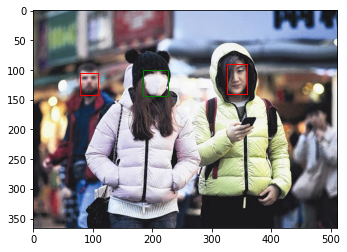

In [ ]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('Before applying transforms')
plot_image_from_output(img, annot)


After applying transforms


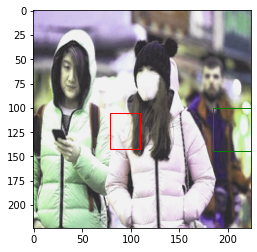

In [ ]:
img, annot, transform_time = torchvision_dataset[0]

print('After applying transforms')
plot_image_from_output(img, annot)

We can see that the mentioned changes have been applied to the image. However, while the image itself has changed, the bounding box has not. We can see that the augmentation provided by `torchvision.transform` only affects the image value, not the location of the bounding box.

For image classification, the label value is fixed even if the image changes. But for object detection, the label value will also change as the image changes. We'll see how to solve this problem in chapter 3.2. First, however, we will continue to compare the torchvision and albumentations modules. We will calculate the time spent converting the image in `torchvision_dataset` and measure the time it will take to repeat it 100 times using the code below.

In [ ]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 10.138509273529053 ms


It took about 10 to 12 ms to perform the image conversion 100 times. In the next section, we will check the augmentation speed of the `albumentations` module.

### 3.1.2. Albumentations

In chapter 3.1.1, we measured the conversion speed of `torchvision.transforms`. In this section, we will look at another augmentation module, `albumentations`. Like we did for `torchvision`, let's first define the dataset class. `AlbumentationDataset` has a similar structure to `TorchVisionDataset`. It reads the image using the `cv2` module and converts it to RGB. After converting the image, the result is returned. 

In [ ]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

For a speed comparison with `torchvision.transform`, let's use the same functions:  `Resize`, `RandomCrop`, `ColorJitter`, and `HorizontalFlip`. Then we will compare the images before and after the change.

In [ ]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

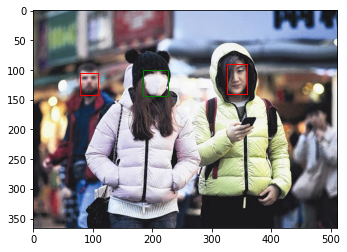

In [ ]:
# Before applying transforms
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

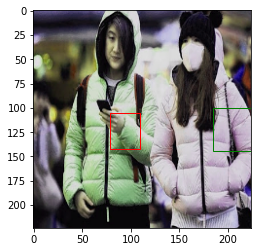

In [ ]:
# After applying transforms
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

Like `torchvision.transform`, the image has been transformed, but the bounding box has not changed. To measure the speed, we will apply `albumentation` 100 times.


In [ ]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 2.1135759353637695 ms


It took about 2.0 to 2.5 ms to perform the image conversion 100 times. Compared to <code>torchvision.transforms</code>, it is about 4 times faster. 

### 3.1.3. Probability-Based Augmentation Combination

`Albmentations` is not only faster than `torchvision.transforms`, but also provides a new function. In this section, we will look at the `OneOf` function provided by Albumentations. This function retrieves the augmentation functions in the list based on a given probability value. The probability value of the list and of the corresponding function are considered together to decide whether or not to execute. The `OneOf` functions below each have a probability of being selected. Since the 3 `albumentations` functions inside each function are also given a probability value of 1, we can see that one of the 3 functions is selected and executed with an actual probability of 1/3. There are various possible augmentations that can be created by adjusting the probability value in this way. 

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

Below is the result of applying <code>albumentations_transform_oneof</code> to an image 10 times. 

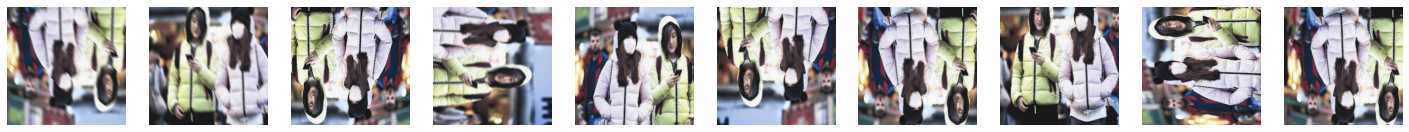

In [ ]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

## 3.2. Bounding Box Augmentation

When performing augmentation on the image used to build the object detection model, the bounding box conversion must be carried out along with the image conversion. As we saw in chapter 3.1, if the bounding box is not converted together, the model training will not work properly because the bounding box is detecting the wrong place. Bounding box augmentation is possible by using the `bbox_params` parameter in the `Compose` function provided by `Albumentations`.

First, let's create a new dataset class using the code below. The transform part of the `AlbumentationsDataset` class in section 3.1.2 has been modified. Not only the image but also the bounding box is being transformed, so the necessary input and output values are modified. 

In [ ]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

Next, let's use the `albumentations.Compose` function to define the transformation. The first thing we will do is perform a horizontal flip, then we will rotate between -90 and 90 degrees. Enter the `albumentations.BboxParams` object into the bbox_params parameter in order to convert the bounding box as well. In the Face Mask Detection dataset, the bounding box notation is `xmin` , `ymin` , `xmax` , `ymax` , which is the same as pascal_voc notation. Therefore, enter pascal_voc in the format parameter. Also, enter `labels` in `label_field` to store the class values for each object in the `labels` parameter when `transform` is performed.

In [ ]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

Now let's activate the `BboxAugmentationDataset` class and check the augmentation result.

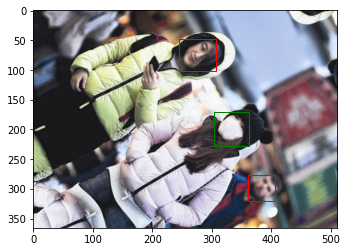

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

Whenever we run the code above, the image is converted and output. In addition to that, the bounding box is also properly transformed so we can see that it accurately detects masked faces in the transformed image. We will build a model in chapters 4 and 5 using the data created by converting the image and bounding box together. 

## 3.3. Data Separation

To build an Artificial Intelligence model, we need training data and test data. The training data is used when training the model, and the test data is used when evaluating the model. Test data must not overlap with training data. Let's divide the data imported in chapter 3.1 into training data and test data. First, let's check the total number of data with the code below. 

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


We can see that there are a total of 853 images. Usually, the ratio of training data to test data is 7:3. This data has a small total compared to more comprehensive datasets, so let's take an 8:2 ratio. In order to use 170 of the 853 data as test data, we will move the data to a separate folder. First, create a folder to contain test data using the Linux command <code>mkdir</code>. 

In [ ]:
!mkdir test_images
!mkdir test_annotations

If we run the code above, the test_images folder and test_annotations folder will be created. Now, we will move 170 files each from the images folder and annotations folder into the newly created folders. We will use the <code>sample</code> function in the <code>random</code> module to randomly extract numbers and use them as index values. 

In [ ]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)


As seen in the code above, we can use the <code>shutil</code> package to move 170 images and 170 annotation files to the test_images folder and test_annotations folder, respectively. Let's check the number of files in each folder.

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


For image classification, you only need to check the number of images after dividing the dataset. But for object detection, it is necessary to check how many objects for each class exist in the dataset. Let's use the code below to check the number of objects by class in the dataset. 

In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n Object in training data', train_objects)
print('\n Object in test data', test_objects)

100%|██████████| 170/170 [00:03<00:00, 52.67it/s]


Object in training data Counter({1: 2691, 0: 532, 2: 97})

Object in test data Counter({1: 541, 0: 185, 2: 26})


ㅤ


`get_num_objects_for_each_class` is a function that stores the label values of all bounding boxes in the dataset in `total_labels` and then uses the `Counter` class to count and return the number of each label. In the training data, there are 532 objects in class 0, 2,691 objects in class 1, and 97 objects in class 2. In the test data, there are 185 objects in class 0, 541 objects in class 1, and 26 objects in class 2. We can confirm that the data is divided appropriately by seeing that the ratio of 0,1,2 is similar for each dataset.

So far, we have seen how to use the <code>Albumentations</code> module to inflate the number of images used to build an object detection model, and we have seen how to separate the owned data into training data and test data. In chapter 4, we will build a mask wearing detection model by training RetinaNet, a one-stage model. 